In [1]:
import torch
from load_data import *

In [3]:
device = torch.device('cuda:2')

# LoadDataset

In [4]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_bank_data()
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


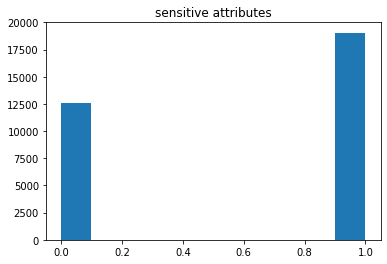

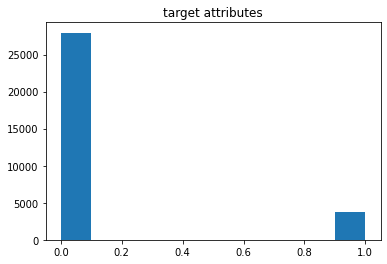

In [5]:
import matplotlib.pyplot as plt
plt.hist(Ztr[:,0])
plt.title("sensitive attributes")
plt.show()
plt.hist(ytr)
plt.title("target attributes")
plt.show()

In [6]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)
print('# output vars', ytr.shape)

sensitive ratio:  [0.39795241]
training default:  [0.88289569]
test default:  [0.88329401]
# training samples: (31647, 46)
# test samples: (13564, 46)
# sensitive vars (31647, 1)
# output vars (31647, 1)


In [7]:
N1 = 300
Xtr1 = Xtr[:N1]
ytr1 = ytr[:N1]
Ztr1 = Ztr[:N1]
Xtr2 = Xtr[N1:]
ytr2 = ytr[N1:]
Ztr2 = Ztr[N1:]

In [8]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training init: ", sum(ytr1==0)/len(ytr1))
print("select init: ", sum(ytr2==0)/len(ytr2))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.39795241]
training init:  [0.91666667]
select init:  [0.88257249]
test default:  [0.88329401]


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
from fairNN_train import *
from load_data import *
from fair_eval import *

In [11]:
class Args:
    def __init__(self):
        self.epochs = 50
#         self.max_epochs = None
        self.AL_iters = 10 # AL batch 몇 번 뽑는지?
        self.AL_batch = 32 # AL 시에 select 되는 데이터 수
        self.batch_size = 64
        self.AL_select = 'acc'
        self.num_classes = 2
#         self.AL_valid = 32
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [12]:
args = Args()

In [13]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=False)

In [14]:
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [15]:
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [16]:
from fairAL_utils import *

In [17]:
n_features = train_data.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf.to(device)

Classifier(
  (network): Sequential(
    (0): Linear(in_features=46, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [18]:
class BinaryEntropyLoss(nn.Module):
    def __init__(self):
        super(BinaryEntropyLoss,self).__init__()
    def forward(self,output):
        ent = -1.0*out

In [19]:
for i,(x,y,_) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(device)
#     print(clf(x)[:,0]>0.5)
#     print(sum(y[:,0]==1).float()/y.size(0),y.size(0),sum(y[:,0]==1).float())
    if i>1:
        break

## compute gradient

In [20]:
clf.eval()

Classifier(
  (network): Sequential(
    (0): Linear(in_features=46, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [41]:
def auto_grad_test(clf,x,y,clf_criterion):
    autograd_hacks.add_hooks(clf)
    clf.zero_grad()
    clear_backprops(clf)
    outs = clf(x)
    count_backprops(clf)
    clf_criterion(outs,y).backward()
    remove_backprops(clf)
    autograd_hacks.compute_grad1(clf)
    tmp = []
    for k, param in enumerate(clf.parameters()):
        tmp.append(param.grad1.reshape(x.size(0),-1))       
    grad_t = torch.cat(tmp,dim=1).detach().cpu()
    return grad_t

In [42]:
clf.network

Sequential(
  (0): Linear(in_features=46, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=32, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=32, out_features=1, bias=True)
)

- https://discuss.pytorch.org/t/enable-anomaly-detection-to-find-the-operation-that-failed-to-compute-its-gradient-with-torch-autograd-set-detect-anomaly-true/95032

In [49]:
def auto_grad_entropy_test(clf,x):
    autograd_hacks.add_hooks(clf)
    clf.zero_grad()
    clear_backprops(clf)
    # this part is needed....
    torch.autograd.set_detect_anomaly(True)
    outs = clf(x)
    count_backprops(clf)
    # we need to set gradient
    outs.backward(gradient = torch.ones(outs.size()).to(device))
    remove_backprops(clf)
    autograd_hacks.compute_grad1(clf)    
    tmp = []
    for k, param in enumerate(clf.parameters()):
        tmp.append(param.grad1.reshape(x.size(0),-1))       
    grad_t = torch.cat(tmp,dim=1).detach().cpu()
    logits = clf.network(x).detach().cpu()
    return -grad_t*logits

In [50]:
grad_ent = auto_grad_entropy_test(clf,x)

In [51]:
print(grad_ent)

tensor([[0.3311, 0.0000, 0.0000,  ..., 0.5092, 0.0000, 0.2059],
        [0.0000, 0.0000, 0.3169,  ..., 0.4758, 0.0000, 0.1874],
        [0.0000, 0.0000, 0.3207,  ..., 0.4881, 0.0000, 0.1897],
        ...,
        [0.0000, 0.0000, 0.0982,  ..., 0.1666, 0.0000, 0.0572],
        [0.2951, 0.0000, 0.0000,  ..., 0.4354, 0.0000, 0.1719],
        [0.3981, 0.0000, 0.0000,  ..., 0.6198, 0.0000, 0.2516]])


- adversarial example jacobiab: https://github.com/ast0414/adversarial-example/blob/master/craft.py
- https://github.com/HIPS/autograd
- https://gist.github.com/sbarratt/37356c46ad1350d4c30aefbd488a4faa 

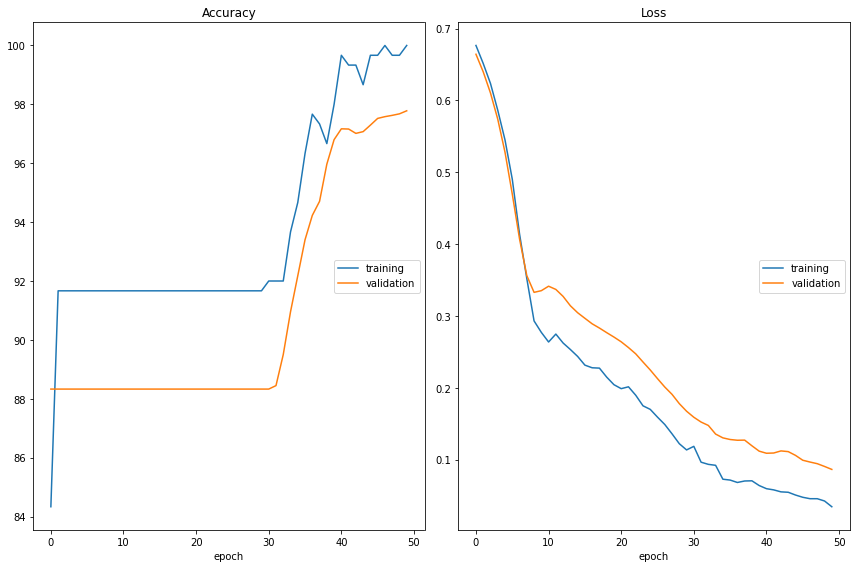

Accuracy
	training         	 (min:   84.333, max:  100.000, cur:  100.000)
	validation       	 (min:   88.329, max:   97.781, cur:   97.781)
Loss
	training         	 (min:    0.034, max:    0.677, cur:    0.034)
	validation       	 (min:    0.086, max:    0.664, cur:    0.086)
Finished Training


In [24]:
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())
train_model(clf, train_loader, clf_criterion, clf_optimizer, device, args.epochs, test_loader, liveloss = None)

In [34]:
import torch
# outs_g = torch.ones(*outs.size())
# outs_g.new_tensor(outs,requires_grad = True)
# outs_g.backward()
autograd_hacks.add_hooks(clf)
clf.zero_grad()
clear_backprops(clf)
torch.autograd.set_detect_anomaly(True)
outs = clf(x)
count_backprops(clf)
outs.backward(gradient = torch.ones(outs.size()).to(device))
remove_backprops(clf)
autograd_hacks.compute_grad1(clf)

In [35]:
tmp = []
for k, param in enumerate(clf.parameters()):
    tmp.append(param.grad1.reshape(x.size(0),-1))       
grad_t = torch.cat(tmp,dim=1).detach().cpu()

In [37]:
print(grad_t.shape)

torch.Size([64, 3649])


In [27]:
outs.grad_fn

In [45]:
gt0.shape

torch.Size([64, 3649])

In [23]:
print(outs_g.grad_fn)

None


In [125]:
clf_criterion(clf(x),y)

tensor(8.6005, device='cuda:1', grad_fn=<BinaryCrossEntropyBackward>)

In [126]:
grado = torch.zeros(*y.size())

In [39]:
from torch.autograd.gradcheck import zero_gradients
grado = grado.to(device)
zero_gradients()

NameError: name 'grado' is not defined

In [44]:
y0 = torch.ones(x.size(0),1).to(device)*0
gt0 = auto_grad_test(clf,x,y0,clf_criterion)
y1 = torch.ones(x.size(0),1).to(device)*1
gt1 = auto_grad_test(clf,x,y1,clf_criterion)
gt_true = auto_grad_test(clf,x,y,clf_criterion)

In [137]:
print(gt0)

tensor([[9.4602e-06, 1.9687e-05, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0857e-05],
        [8.9625e-02, 3.4506e-01, 0.0000e+00,  ..., 7.5239e-01, 0.0000e+00,
         8.5439e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.9524e-03],
        ...,
        [7.1622e-05, 1.3787e-04, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         7.6029e-05],
        [8.7801e-04, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.9948e-03],
        [3.7617e-06, 1.6092e-05, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.8737e-06]])


In [138]:
print(gt1)

tensor([[-0.8714, -1.8134, -0.0000,  ..., -0.0000, -0.0000, -1.0000],
        [-0.0153, -0.0588, -0.0000,  ..., -0.1282, -0.0000, -0.1456],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000, -0.9980],
        ...,
        [-0.9420, -1.8133, -0.0000,  ..., -0.0000, -0.0000, -0.9999],
        [-0.4393, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.9980],
        [-0.4239, -1.8134, -0.0000,  ..., -0.0000, -0.0000, -1.0000]])


In [139]:
print(gt_true)

tensor([[ 9.4602e-06,  1.9687e-05,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.0857e-05],
        [-1.5275e-02, -5.8807e-02, -0.0000e+00,  ..., -1.2823e-01,
         -0.0000e+00, -1.4561e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.9524e-03],
        ...,
        [ 7.1622e-05,  1.3787e-04,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  7.6029e-05],
        [ 8.7801e-04,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.9948e-03],
        [ 3.7617e-06,  1.6092e-05,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  8.8737e-06]])


In [119]:
gt0*(1-outs) + gt1*outs

tensor([[ 0.0000e+00,  2.3283e-10,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -3.6380e-12],
        ...,
        [-3.6380e-12,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 9.0949e-13,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.8626e-09,  7.4506e-09,  0.0000e+00,  ...,  1.4901e-08,
          0.0000e+00,  1.4901e-08]])

In [112]:
torch.cat(tmp,dim=1).detach().cpu()*outs

tensor([[-1.4099e-03, -3.1929e-03, -0.0000e+00,  ..., -0.0000e+00,
         -0.0000e+00, -1.6958e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
         -0.0000e+00, -5.2104e-07],
        [-3.7686e-05, -9.0681e-05, -0.0000e+00,  ..., -0.0000e+00,
         -0.0000e+00, -5.0006e-05],
        ...,
        [-3.1681e-05, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
         -0.0000e+00, -7.4734e-05],
        [-1.3059e-05, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
         -0.0000e+00, -4.2655e-05],
        [-1.0612e-02, -3.8909e-02, -0.0000e+00,  ..., -1.0160e-01,
         -0.0000e+00, -9.8253e-02]])

In [107]:
print(1-outs)

tensor([[0.9983],
        [1.0000],
        [0.9999],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9999],
        [0.9999],
        [1.0000],
        [0.9998],
        [0.9992],
        [1.0000],
        [0.9998],
        [0.9974],
        [0.9995],
        [0.9988],
        [0.9972],
        [0.9999],
        [1.0000],
        [0.9996],
        [0.9997],
        [0.9957],
        [1.0000],
        [0.1192],
        [0.9997],
        [1.0000],
        [0.1673],
        [0.9998],
        [1.0000],
        [0.1242],
        [0.9998],
        [0.9999],
        [0.9997],
        [0.9999],
        [0.9999],
        [0.9997],
        [1.0000],
        [0.9999],
        [0.1456],
        [1.0000],
        [0.9982],
        [1.0000],
        [0.9996],
        [1.0000],
        [0.9999],
        [1.0000],
        [1.0000],
        [0.9998],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9999],
        [0.9999],
        [0.9999],
        [1.0000],
        [0

In [105]:
print(grad_t)

tensor([[ 1.4123e-03,  3.1983e-03,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.6987e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  5.2104e-07],
        [ 3.7687e-05,  9.0685e-05,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  5.0008e-05],
        ...,
        [ 3.1683e-05,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  7.4739e-05],
        [ 1.3060e-05,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  4.2657e-05],
        [-1.1929e-02, -4.3741e-02, -0.0000e+00,  ..., -1.1422e-01,
         -0.0000e+00, -1.1045e-01]])


In [70]:


print(y[:,0])

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False], device='cuda:1')
tensor(0.0556) 36 tensor(2.)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [92]:
test_model(clf, train_loader, clf_criterion, device)

(tensor(0.0124), tensor(100.))